In [1]:
import sys
import os 
from os import path
import re
import nltk
import pickle

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from nltk.corpus import stopwords
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [2]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
train = pd.read_csv('data/train.csv')

In [4]:
train.head()

id                                               text  target
0   0  \nThey were, and even if Washington might cons...      10
1   1  We run "SpaceNews & Views" on our STAREACH BBS...      14
2   2  \n\n\nNot to worry.  The Masons have been demo...      19
3   3  Only Brendan McKay, or maybe ARF, would come t...      17
4   4  Help: I am running some sample problems from O...       5

In [5]:
# 결측치 확인
def checking_missing_col(df):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(df.columns):
        missing_values = sum(df[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은:{col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, df[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = checking_missing_col(train)

결측치가 존재하지 않습니다


In [6]:
# 기초 통계 분석
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9233 entries, 0 to 9232
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9233 non-null   int64 
 1   text    9233 non-null   object
 2   target  9233 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 216.5+ KB


In [7]:
train['text']

0       \nThey were, and even if Washington might cons...
1       We run "SpaceNews & Views" on our STAREACH BBS...
2       \n\n\nNot to worry.  The Masons have been demo...
3       Only Brendan McKay, or maybe ARF, would come t...
4       Help: I am running some sample problems from O...
                              ...                        
9228    \n\nPrecisely, why not Cuba??  Why not???  The...
9229    Your Custom Resume On Disk!\n \n              ...
9230    Throughout the years of the Israel/Arab-Palest...
9231    Does anyone know if there are any devices avai...
9232    \n\n      Give ME a break, chum.  Are you tell...
Name: text, Length: 9233, dtype: object

In [8]:
# 전처리
def clean_text(texts):
    corpus = []
    for i in range(len(texts)):
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
        review = re.sub(r'\d+','', review)#숫자 제거
        review = review.lower() #소문자 변환
        review = re.sub(r'\s+', ' ', review) #extra space 제거
        review = re.sub(r'<[^>]+>','',review) #Html tags 제거
        review = re.sub(r'\s+', ' ', review) #spaces 제거
        review = re.sub(r"^\s+", '', review) #space from start 제거
        review = re.sub(r'\s+$', '', review) #space from the end 제거
        review = re.sub(r'_', ' ', review) #space from the end 제거
        corpus.append(review) 
    return corpus

In [9]:
train['text'] = clean_text(train['text'])

In [10]:
train.head()

id                                               text  target
0   0  they were and even if washington might conside...      10
1   1  we run spacenews views on our stareach bbs a l...      14
2   2  not to worry the masons have been demonized an...      19
3   3  only brendan mckay or maybe arf would come to ...      17
4   4  help i am running some sample problems from or...       5

In [11]:
# 뉴스 그룹 비율 확인
val_count = train['target'].value_counts()

for i in range(20):
    print(f'라벨{i}인 리뷰 개수:', val_count[i])

라벨0인 리뷰 개수: 386
라벨1인 리뷰 개수: 480
라벨2인 리뷰 개수: 458
라벨3인 리뷰 개수: 467
라벨4인 리뷰 개수: 490
라벨5인 리뷰 개수: 496
라벨6인 리뷰 개수: 494
라벨7인 리뷰 개수: 493
라벨8인 리뷰 개수: 475
라벨9인 리뷰 개수: 490
라벨10인 리뷰 개수: 482
라벨11인 리뷰 개수: 488
라벨12인 리뷰 개수: 483
라벨13인 리뷰 개수: 490
라벨14인 리뷰 개수: 467
라벨15인 리뷰 개수: 515
라벨16인 리뷰 개수: 428
라벨17인 리뷰 개수: 455
라벨18인 리뷰 개수: 387
라벨19인 리뷰 개수: 309


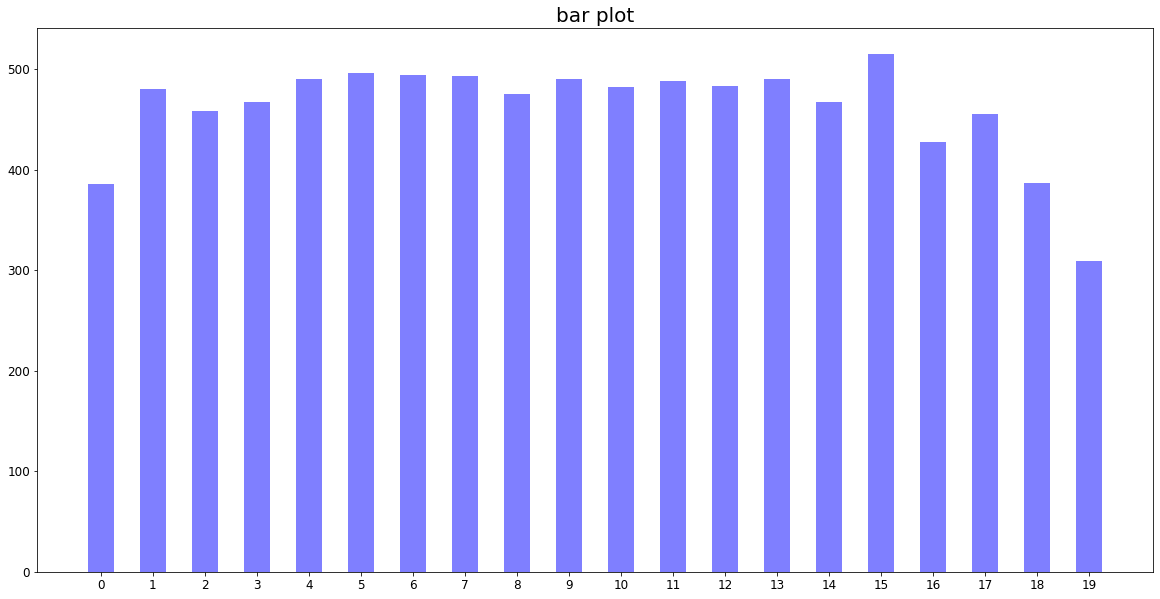

In [12]:
# 데이터 시각화
temp = train['target'].value_counts()
plt.figure(figsize=(20,10))
plt.title('bar plot', fontsize=20)
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5)
plt.xticks(temp.keys(), fontsize=12)
plt.show()
# save_fig('label group counts')

In [13]:
# 뉴스 text 길이 확인
str_len_mean = np.mean(train['text'].str.len())
print('뉴스의 평균 길이:', round(str_len_mean,0))

뉴스의 평균 길이: 1020.0


In [14]:
# 데이터 필터링을 위한 마스크 설정
for i in range(20):
    globals()['mask_{}'.format(i)] = (train['target'] == i)

In [15]:
train[mask_0]

id                                               text  target
52      52  deleted stuff from andrew wrt which atheist my...       0
56      56  deletia in case anybody hadnt noticed frank an...       0
95      95  due to a discussion on this group some time ag...       0
113    113  no bobby stalin killed millions in the name of...       0
139    139  issued by khomeini it shouldnt be relevant to ...       0
...    ...                                                ...     ...
9116  9116  wait a minute i thought you said that allah i ...       0
9138  9138  i recall a discussion i had heard years ago it...       0
9149  9149  i wonder how many atheists out there care to s...       0
9171  9171  are you saying that their was a physical adam ...       0
9226  9226  id like this too maybe you should post an answ...       0

[386 rows x 3 columns]

In [16]:
# 전체 및 그룹 집합을 설정
df_train = train['text'].copy()

for i in range(20):
    globals()['df_{}'.format(i)] = train.loc[globals()['mask_{}'.format(i)],:]['text']

In [17]:
compare = [df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12, df_13, df_14, df_15, df_16, df_17, df_18, df_19]

In [18]:
df_0

52      deleted stuff from andrew wrt which atheist my...
56      deletia in case anybody hadnt noticed frank an...
95      due to a discussion on this group some time ag...
113     no bobby stalin killed millions in the name of...
139     issued by khomeini it shouldnt be relevant to ...
                              ...                        
9116    wait a minute i thought you said that allah i ...
9138    i recall a discussion i had heard years ago it...
9149    i wonder how many atheists out there care to s...
9171    are you saying that their was a physical adam ...
9226    id like this too maybe you should post an answ...
Name: text, Length: 386, dtype: object

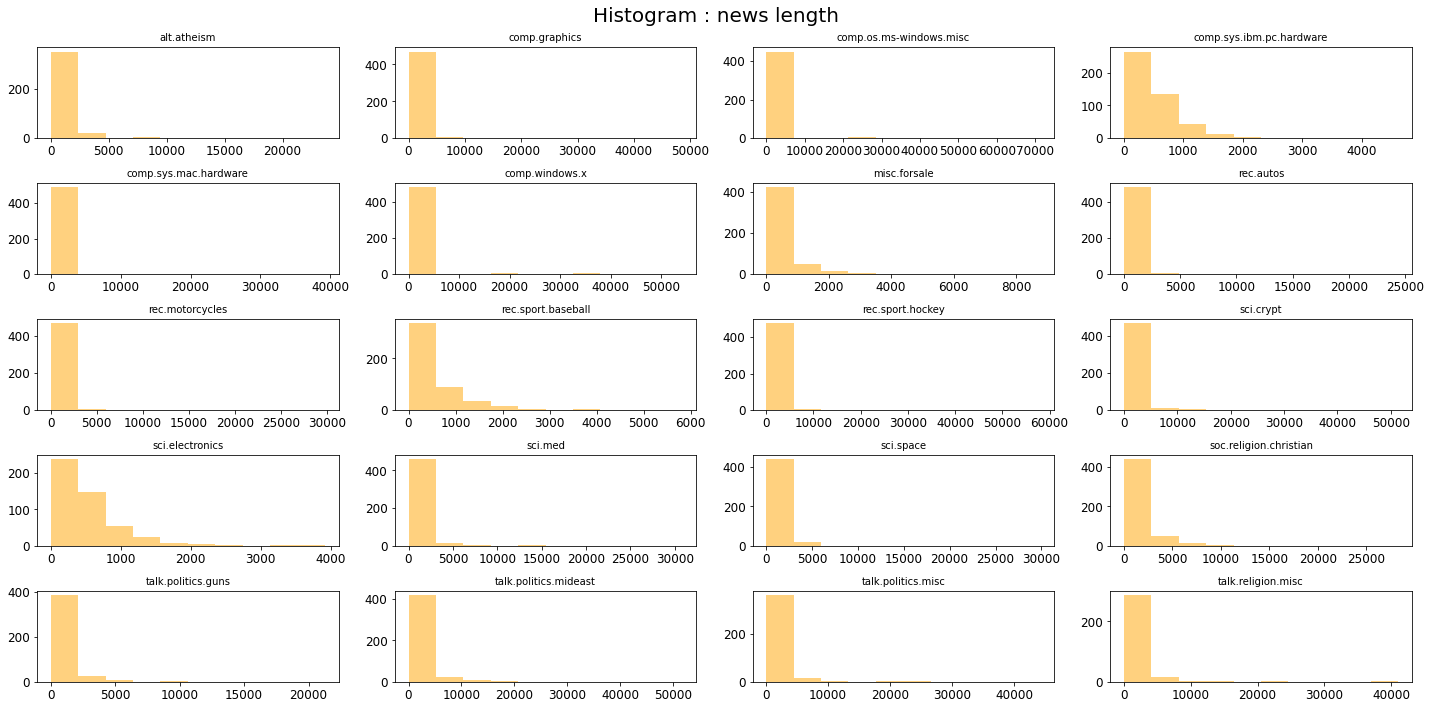

In [19]:
# 히스토그램을 사용해서 데이터 분포를 살펴봄
plt.figure(figsize=(20, 10))
plt.suptitle('Histogram : news length', fontsize=20)
name = ['alt.atheism', # 0
        'comp.graphics', # 1
        'comp.os.ms-windows.misc', # 2
        'comp.sys.ibm.pc.hardware', # 3
        'comp.sys.mac.hardware', # 4
        'comp.windows.x', # 5
        'misc.forsale', # 6
        'rec.autos', # 7
        'rec.motorcycles', # 8
        'rec.sport.baseball', # 9
        'rec.sport.hockey', # 10
        'sci.crypt', # 11
        'sci.electronics', # 12
        'sci.med', # 13
        'sci.space', # 14
        'soc.religion.christian', # 15
        'talk.politics.guns', # 16
        'talk.politics.mideast', # 17
        'talk.politics.misc', # 18
        'talk.religion.misc'] # 19

for i in range(len(compare)):
    text = compare[i]
    string_len = [len(x) for x in text]
    plt.subplot(5,4,i+1)
    plt.title(name[i], fontsize=10)
#     plt.axis([0, 50000, 0, 10])
    plt.hist(string_len, alpha=0.5, color='orange')

plt.tight_layout()
plt.show()
# save_fig('Histogram : news length')

In [ ]:
# wordcloud

In [52]:
def NN_word(tokens_pos):
    NN_words = []
    for word, pos in tokens_pos:
        if 'NN' in pos:
            NN_words.append(word)
    return NN_words

def lemmatized_word(NN_words):
    lemmatized_words = []
    for word in NN_words:
        new_words = wlem.lemmatize(word)
        lemmatized_words.append(new_words)
    return lemmatized_words

def unique_NN_word(lemmatized_words):
    unique_NN_words = set(lemmatized_words)
    final_NN_words = lemmatized_words

    for word in unique_NN_words:
        if word in stopwords_list:
            while word in final_NN_words:final_NN_words.remove(word)  
    return final_NN_words

def count_word(final_NN_words, k):
    c = Counter(final_NN_words)
    top_10 = c.most_common(k)
    keys = [top_10[i][0] for i in range(len(top_10))]
    values = [top_10[i][1] for i in range(len(top_10))]
    return keys, values

In [42]:
wlem = nltk.WordNetLemmatizer()
stopwords_list = stopwords.words('english')

In [43]:
word_tokens = nltk.word_tokenize(''.join(compare[0]))
tokens_pos = nltk.pos_tag(word_tokens)

In [44]:
NN_words = NN_words(tokens_pos)

In [45]:
lemmatized_words = lemmatized_words(NN_words)

In [46]:
final_NN_words = unique_NN_words(lemmatized_words)

In [47]:
keys, values = count_word(final_NN_words, 10)

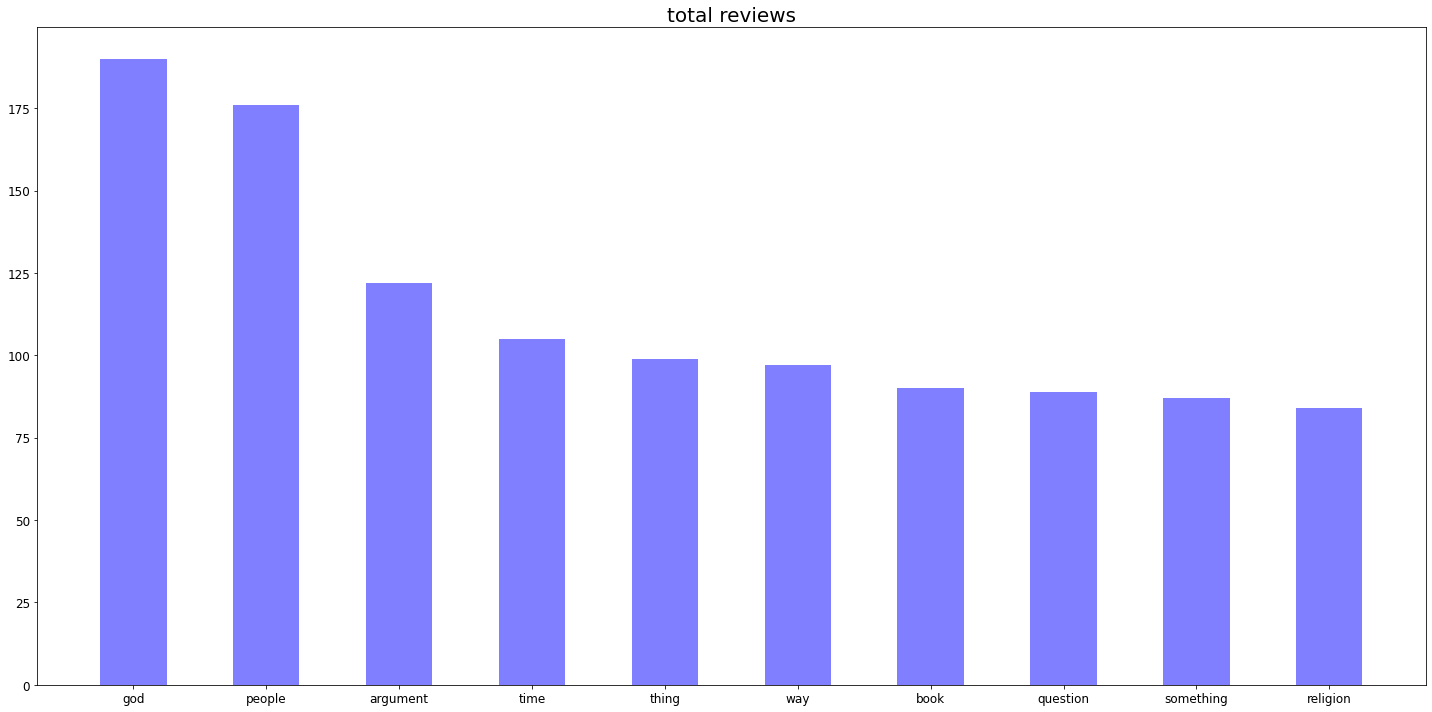

In [48]:
plt.figure(figsize=(20, 10))
plt.title('total reviews', fontsize=20)
plt.bar(keys, values, width=0.5, color='b', alpha=0.5)
plt.tight_layout()
plt.show()

그림 저장: wordcloud


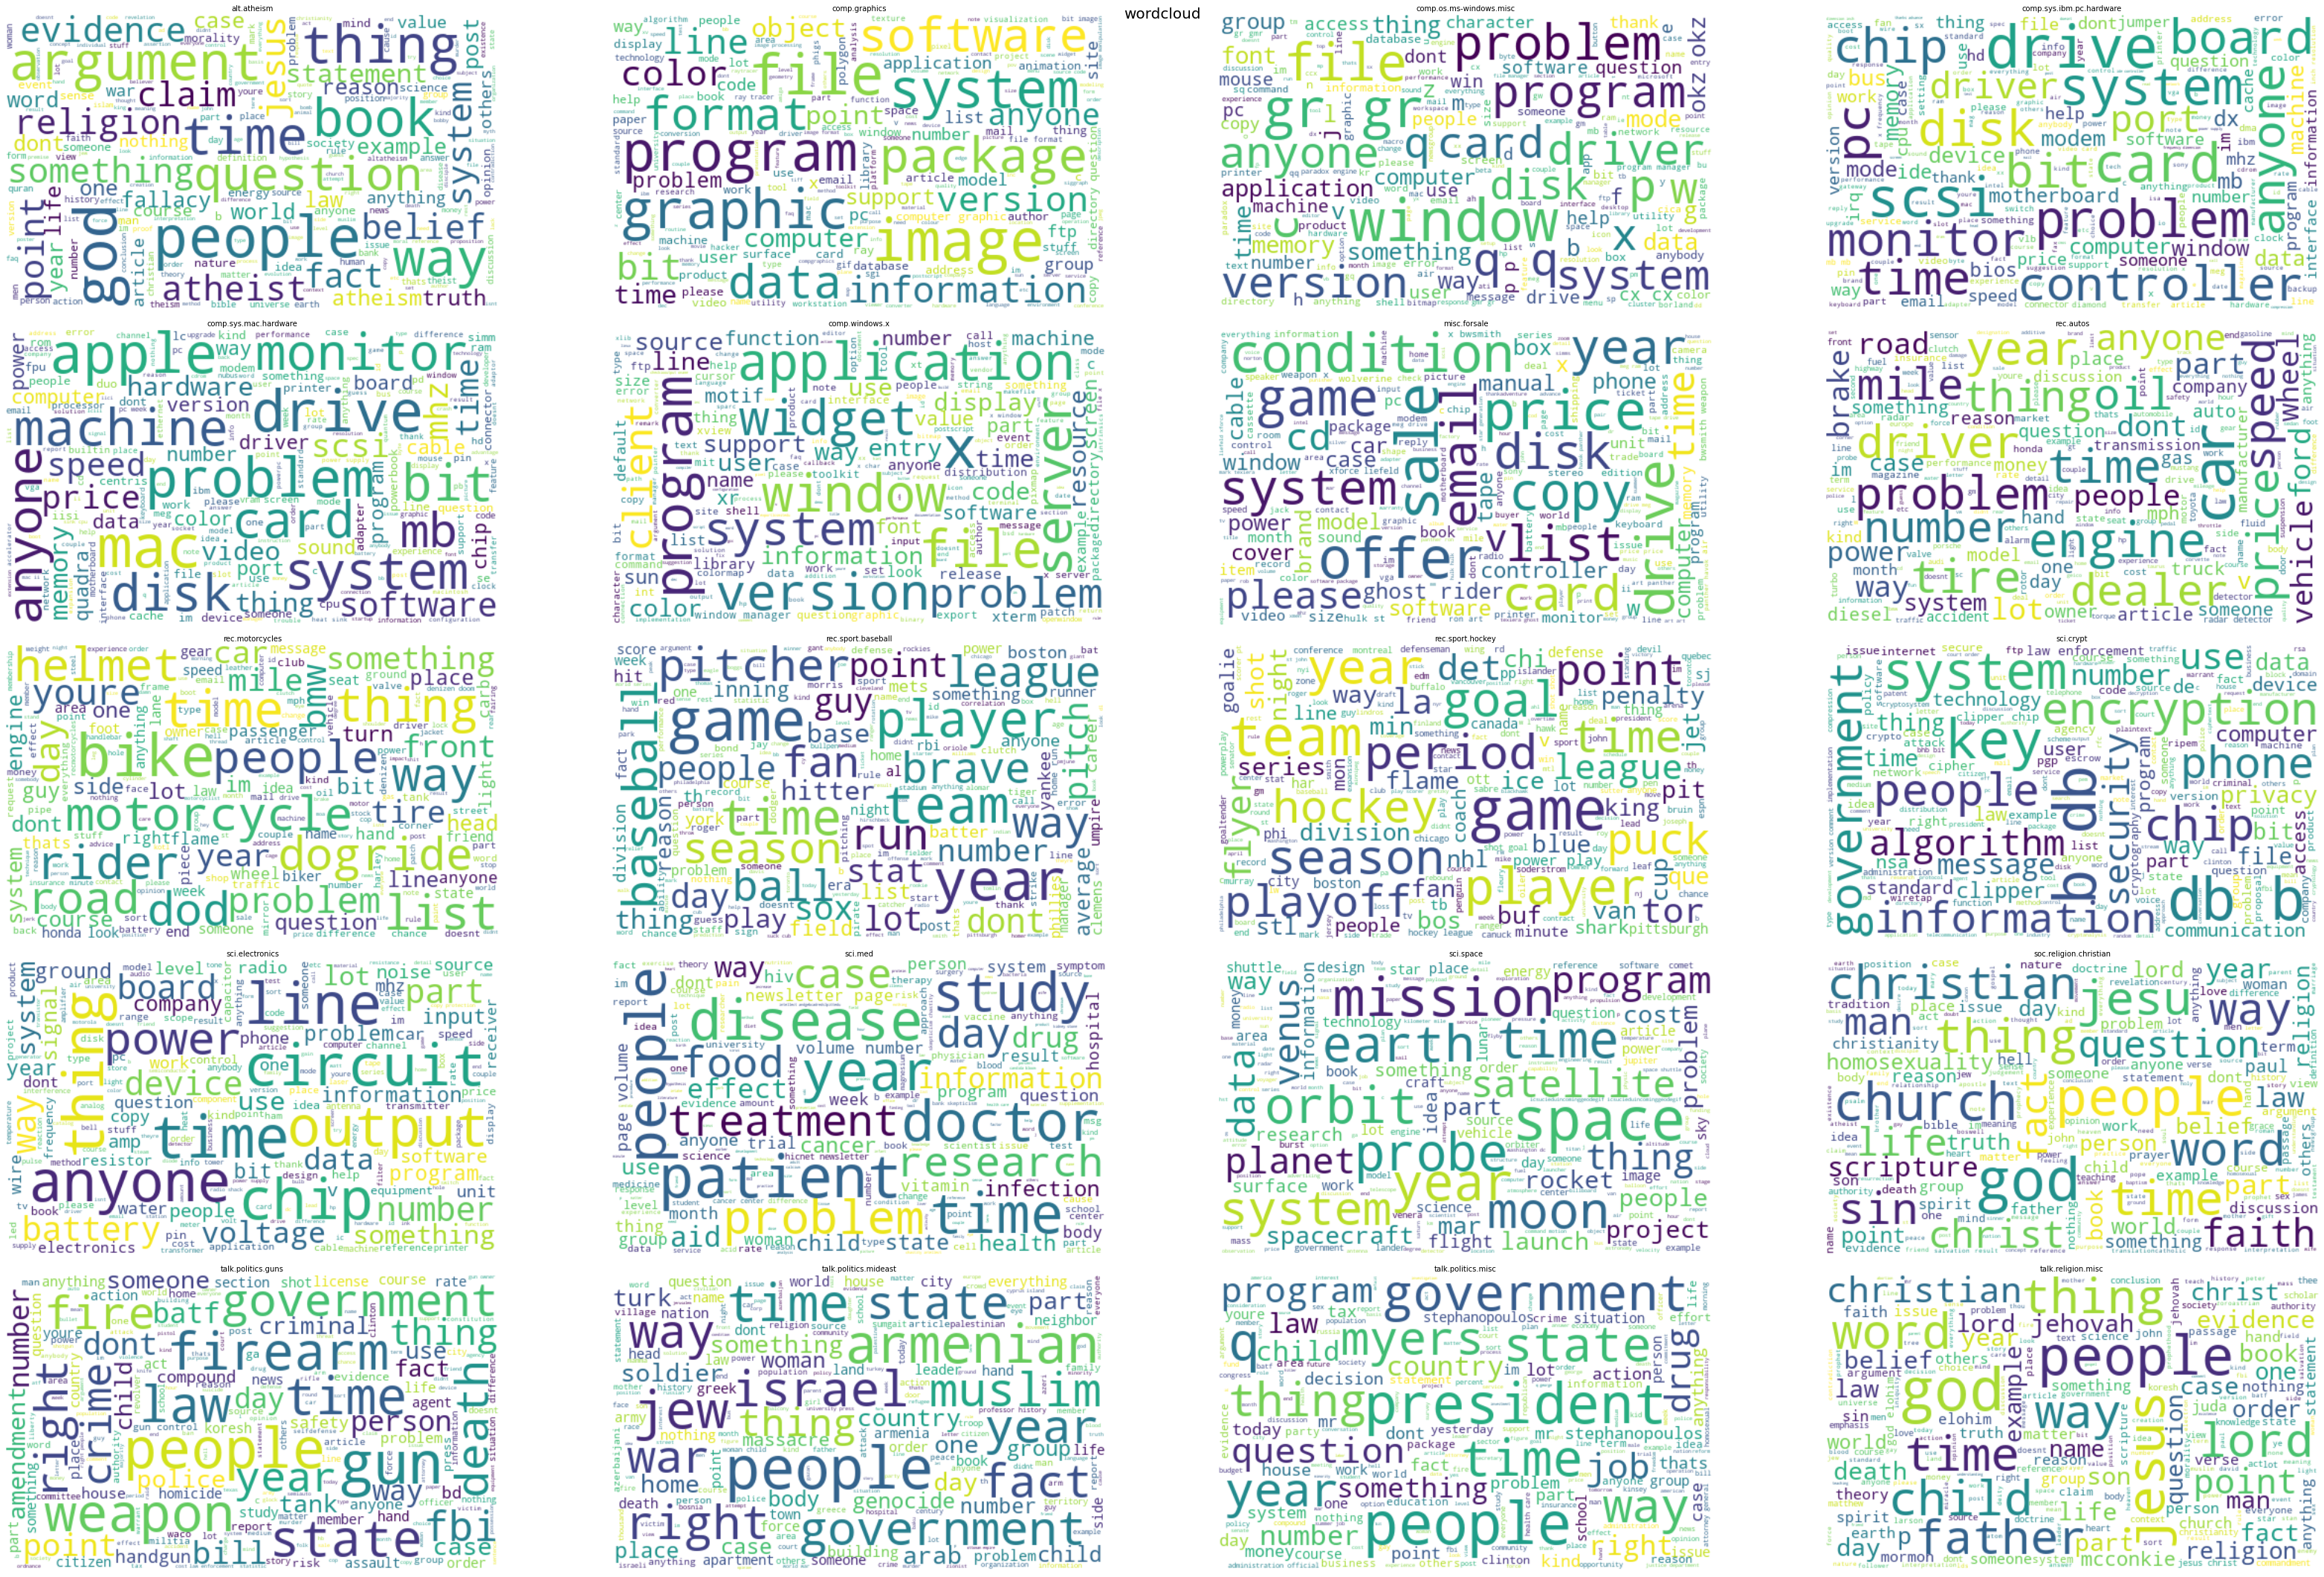

In [57]:
plt.figure(figsize=(50, 30))
plt.suptitle('wordcloud', fontsize=20)

for i in range(20):
    word_tokens = nltk.word_tokenize(''.join(compare[i]))
    tokens_pos = nltk.pos_tag(word_tokens)
    NN_words = NN_word(tokens_pos)
    lemmatized_words = lemmatized_word(NN_words)
    final_NN_words = unique_NN_word(lemmatized_words)
    noun_text = ' '.join(final_NN_words)
    wordcloud = WordCloud(max_font_size=59, width=500, height=300, background_color='white', relative_scaling=.2).generate(noun_text)
    plt.subplot(5,4,i+1)
    plt.title(name[i], fontsize=10)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

# plt.tight_layout()
# plt.show()
save_fig('wordcloud')